# Evaluation

In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import os
import fnmatch

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas(leave=False, desc='Evaluate')

import sys
sys.path.insert(0, '../../src')
import utils.visualization as vis
import utils.preprocession as prep
from utils.metrics import compute_metric


In [2]:
save_figures = True

results = [] 
for dirpath, _, filenames in os.walk("../../embeddings"):
    for filename in fnmatch.filter(filenames, 'metrics.csv'):
        path = os.path.join(dirpath, filename)
        results.append(pd.read_csv(path, index_col=0))
results.append(pd.read_csv("../../results/baseline_metrics.csv"))
results = pd.concat(results, axis=0)
results = results.loc[results['Embedding Method'] != 'ITSVM']

In [3]:
def compareMethods(dataset, datatype, stage, task, fit_zero=False, ax=None):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(vis.textwidth, 0.5*vis.textwidth))

    if fit_zero:
        comparison = 0
        xlabel = 'Evaluation'
    else:
        xlabel = 'Train'
        comparison = results['Evaluation Sparsity']

    data = results.loc[ (results['Dataset'] == dataset) 
                    & (results['Datatype'] == datatype) 
                    & (results['Evaluation Set'] == stage) 
                    & (results['Task'] == task)
                    & (results['Train Sparsity'] == comparison)
                    ].set_index(['Embedding Method', 'Prediction Method', f'{xlabel} Sparsity']
                    ).loc[:,['Accuracy', 'RMSE']
                    ].unstack(['Embedding Method', 'Prediction Method'])
    
    # ax = data['Accuracy'].plot(ax=ax)
    # ax = data['RMSE'].plot(ax=ax)
    for i, column in enumerate(data['Accuracy']):
        ax.plot(data['Accuracy'].index, data['Accuracy'][column], color='C'+str(i), linestyle='-', label=f'{column}')  # First plot for each column
    
    for i, column in enumerate(data['RMSE']):
        ax.plot(data['RMSE'].index, data['RMSE'][column], color='C'+str(i), linestyle='-')  # Second plot, slightly transparent

    ax.grid(True)
    ax.set_title(f"{stage} {task} results for {datatype} {dataset}")
    return fig, ax, data

def overviewTrain(dataset, datatype):
    fig, axes = plt.subplots(2,2,figsize=(8,8))
    for i, task in enumerate(['Fit', 'Impute']):
        for j, stage in enumerate(['Train', 'Test']):
            _, ax, _ = compareMethods(dataset, datatype, stage, task, fit_zero=False, ax=axes[i,j])
            ax.set(ylim=(0,1),
                   xlim=(0,100))
            axes[i,j].legend().remove()
    # Create a shared legend
    # Use one of the line objects from the subplots for the legend
    lines, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(lines, labels, ncol=1, loc='center left',bbox_to_anchor=(1.0, 0.5))

    # Adjust layout
    fig.tight_layout()
    return fig

[Text(0.5, 0, 'Ratio of Missing Values'), Text(0, 0.5, 'Accuracy/RMSE')]

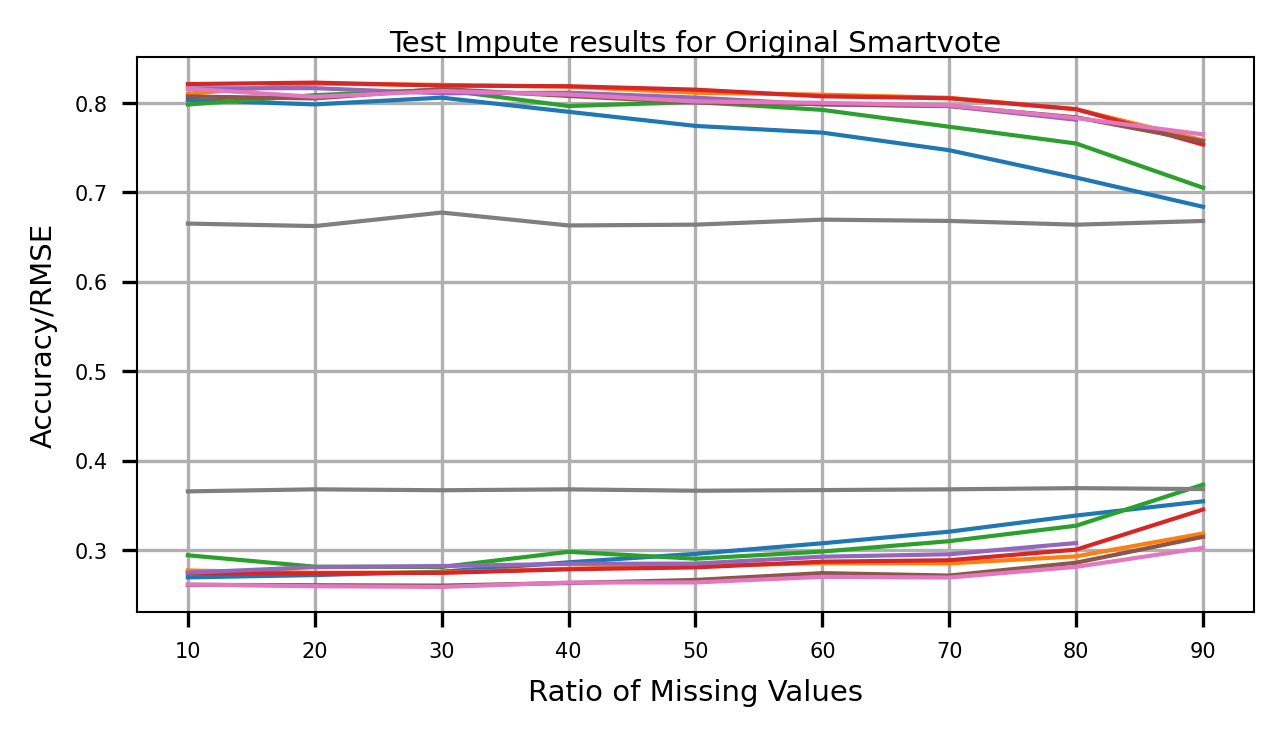

In [7]:
fig, ax, data = compareMethods('Smartvote', 'Original', 'Test', 'Impute')
ax.set(xlabel='Ratio of Missing Values',
       ylabel='Accuracy/RMSE')

[Text(0.5, 0, 'Ratio of Missing Values'), Text(0, 0.5, 'Accuracy/RMSE')]

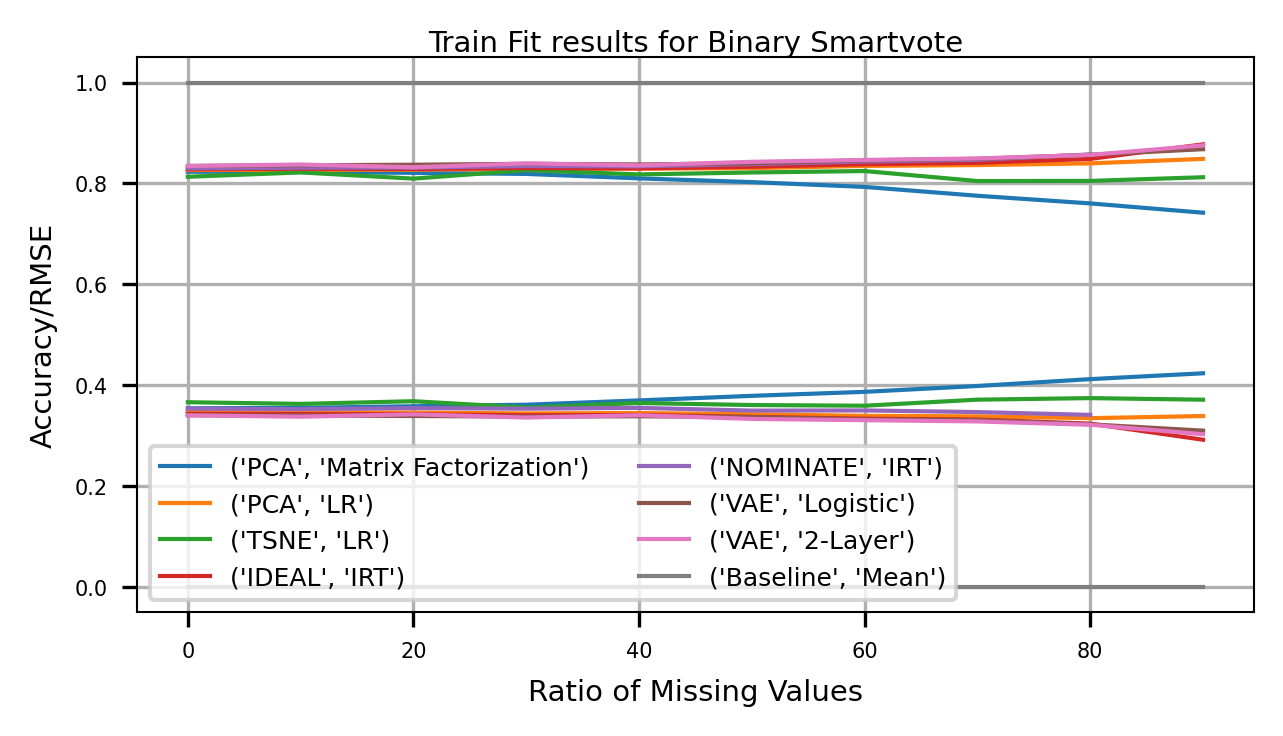

In [8]:
fig, ax, data = compareMethods('Smartvote', 'Binary', 'Train', 'Fit')
ax.legend(ncol=2, facecolor='white')
ax.set(xlabel='Ratio of Missing Values',
       ylabel='Accuracy/RMSE')

[Text(0.5, 0, 'Ratio of Missing Values'), Text(0, 0.5, 'Accuracy/RMSE')]

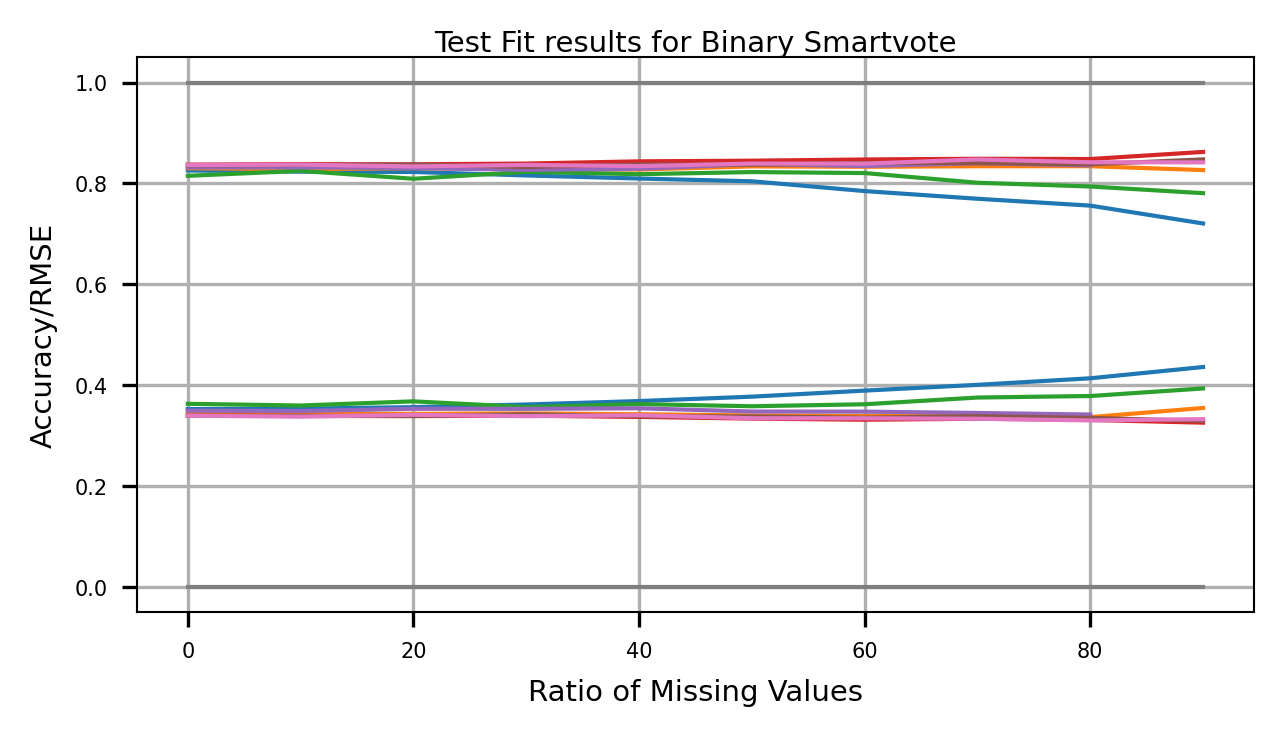

In [9]:
fig, ax, data = compareMethods('Smartvote', 'Binary', 'Test', 'Fit')
ax.set(xlabel='Ratio of Missing Values',
       ylabel='Accuracy/RMSE')

In [10]:
def compareMethods(dataset, datatype, stage, task, fit_zero=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    if fit_zero:
        comparison = 0
        xlabel = 'Evaluation'
    else:
        xlabel = 'Train'
        comparison = results['Evaluation Sparsity']

    data = results.loc[ (results['Dataset'] == dataset) 
                    & (results['Datatype'] == datatype) 
                    & (results['Evaluation Set'] == stage) 
                    & (results['Task'] == task)
                    & (results['Train Sparsity'] == comparison)
                    ].set_index(['Embedding Method', 'Prediction Method', f'{xlabel} Sparsity']
                    ).loc[:,['Accuracy', 'RMSE']
                    ].unstack(['Embedding Method', 'Prediction Method'])
    
    ax = data.plot(ax=ax)
    ax.grid(True)
    ax.set_title(f"{stage} {task} results for {datatype} {dataset}")
    return ax, data

def overviewTrain(dataset, datatype):
    fig, axes = plt.subplots(2,2,figsize=(8,8))
    for i, task in enumerate(['Fit', 'Impute']):
        for j, stage in enumerate(['Train', 'Test']):
            ax, _ = compareMethods(dataset, datatype, stage, task, fit_zero=False, ax=axes[i,j])
            ax.set(ylim=(0,1),
                   xlim=(0,100))
            axes[i,j].legend().remove()
    # Create a shared legend
    # Use one of the line objects from the subplots for the legend
    lines, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(lines, labels, ncol=1, loc='center left',bbox_to_anchor=(1.0, 0.5))

    # Adjust layout
    plt.tight_layout()
    return fig

## Synthetic Data

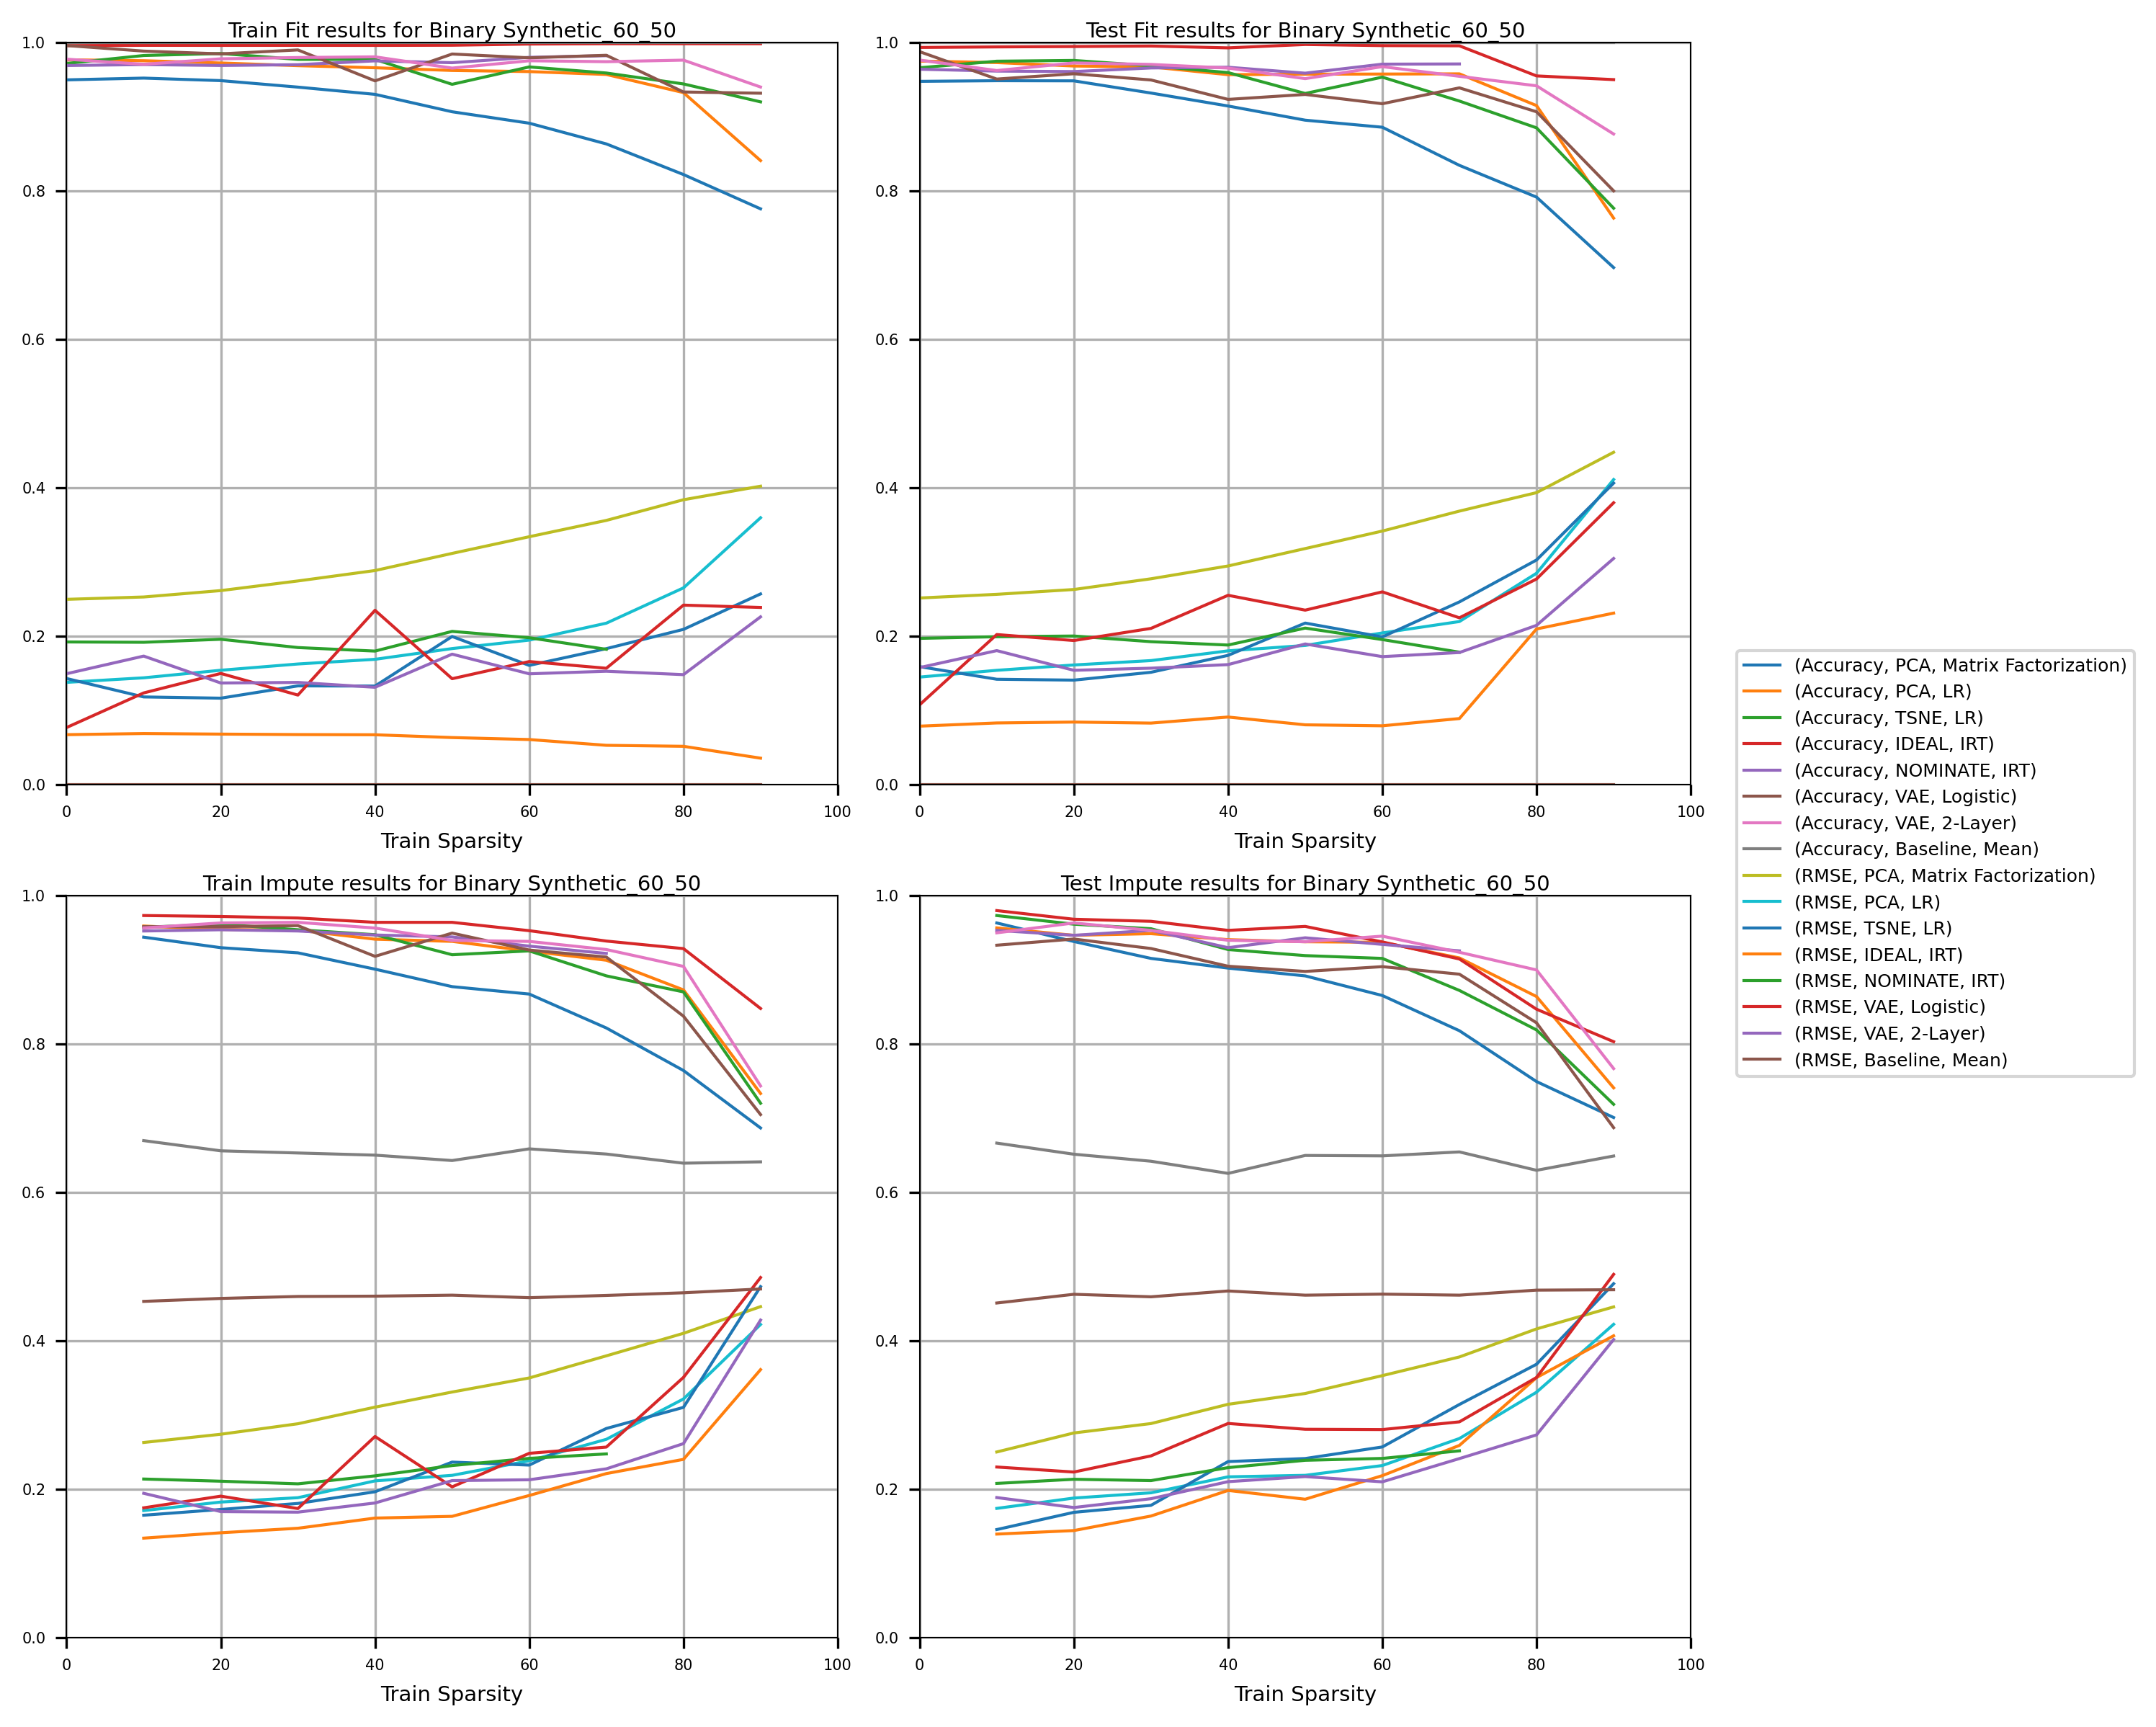

In [11]:
fig = overviewTrain('Synthetic_60_50', 'Binary')

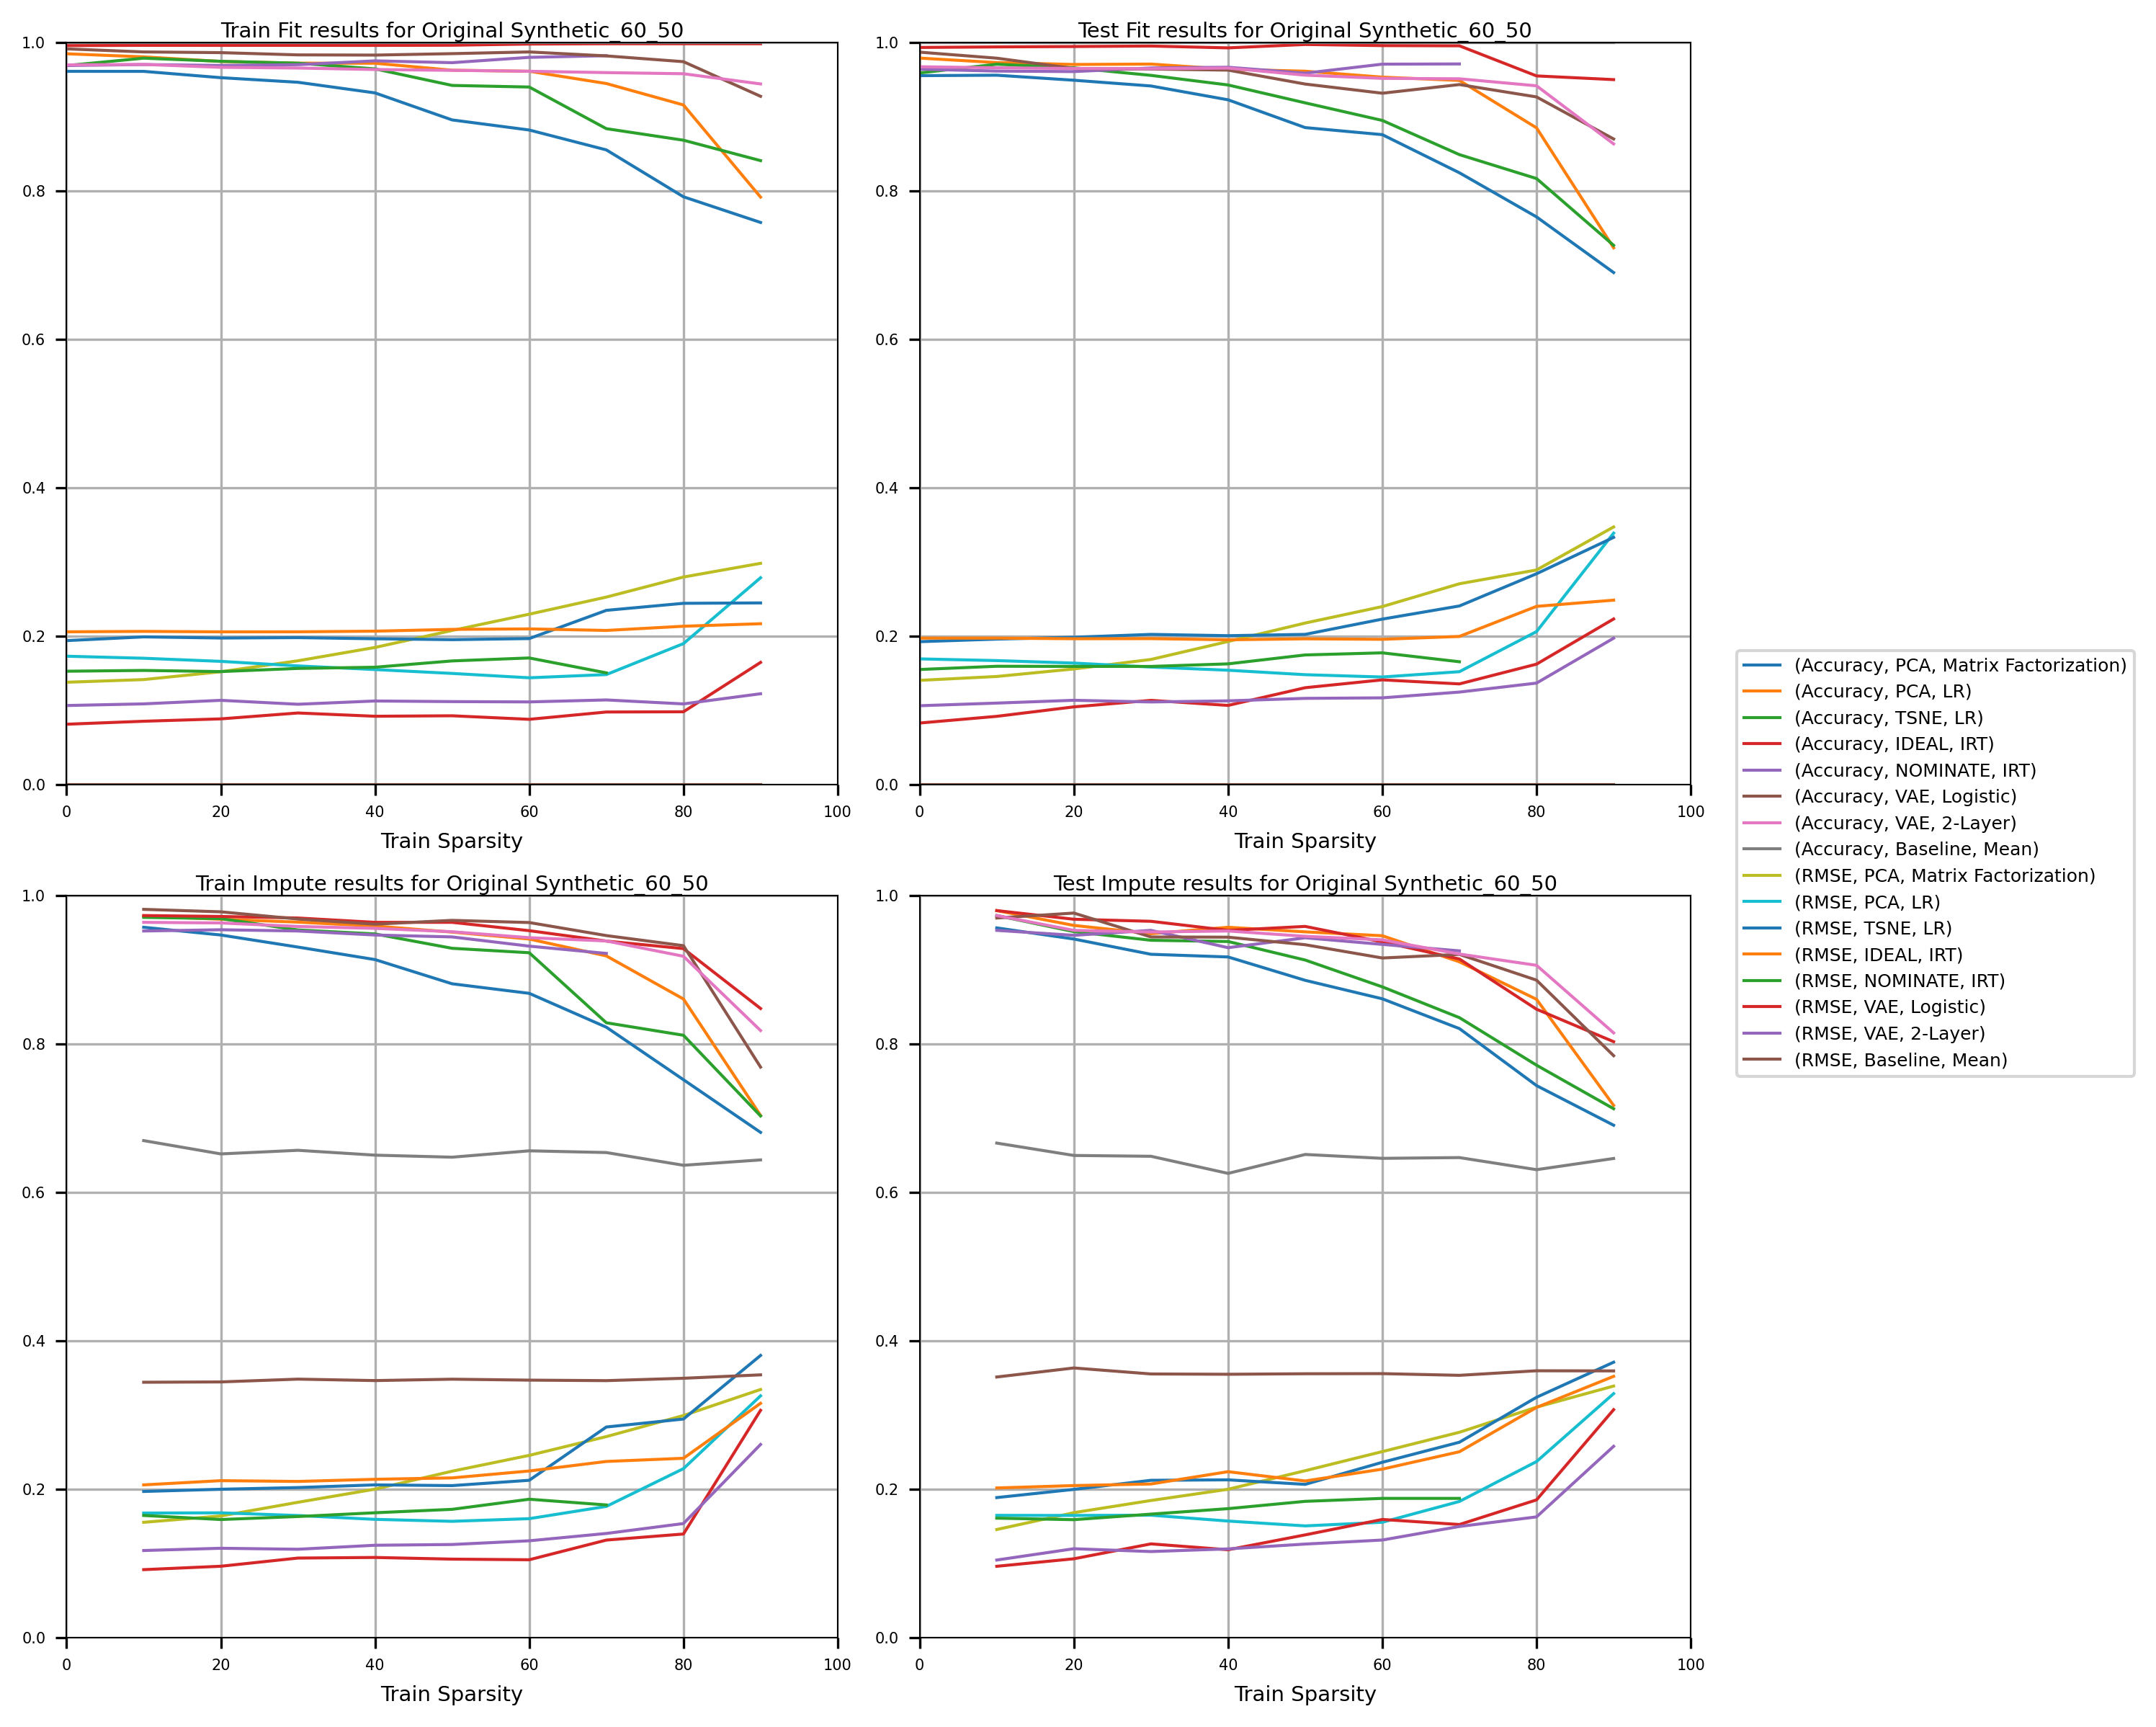

In [12]:
fig = overviewTrain('Synthetic_60_50', 'Original')

### Fit Zero Variant

In [13]:
def overviewFitZero(dataset, datatype):
    fig, axes = plt.subplots(1,2,figsize=(vis.textwidth,0.5*vis.textwidth))
    for i, task in enumerate(['Fit', 'Impute']):
        ax, _ = compareMethods(dataset, datatype, 'Test', task, fit_zero=True, ax=axes[i])
        ax.set(ylim=(0,1),
                xlim=(0,100),
                xlabel='Ratio of Missing Values in Test Set',
                ylabel='Accuracy/RMSE')          
        axes[i].legend().remove()
    # Create a shared legend
    # Use one of the line objects from the subplots for the legend
    lines, labels = axes[0].get_legend_handles_labels()
    fig.legend(lines, labels, ncol=1, loc='center left',bbox_to_anchor=(1.0, 0.5))

    # Adjust layout
    plt.tight_layout()
    return fig

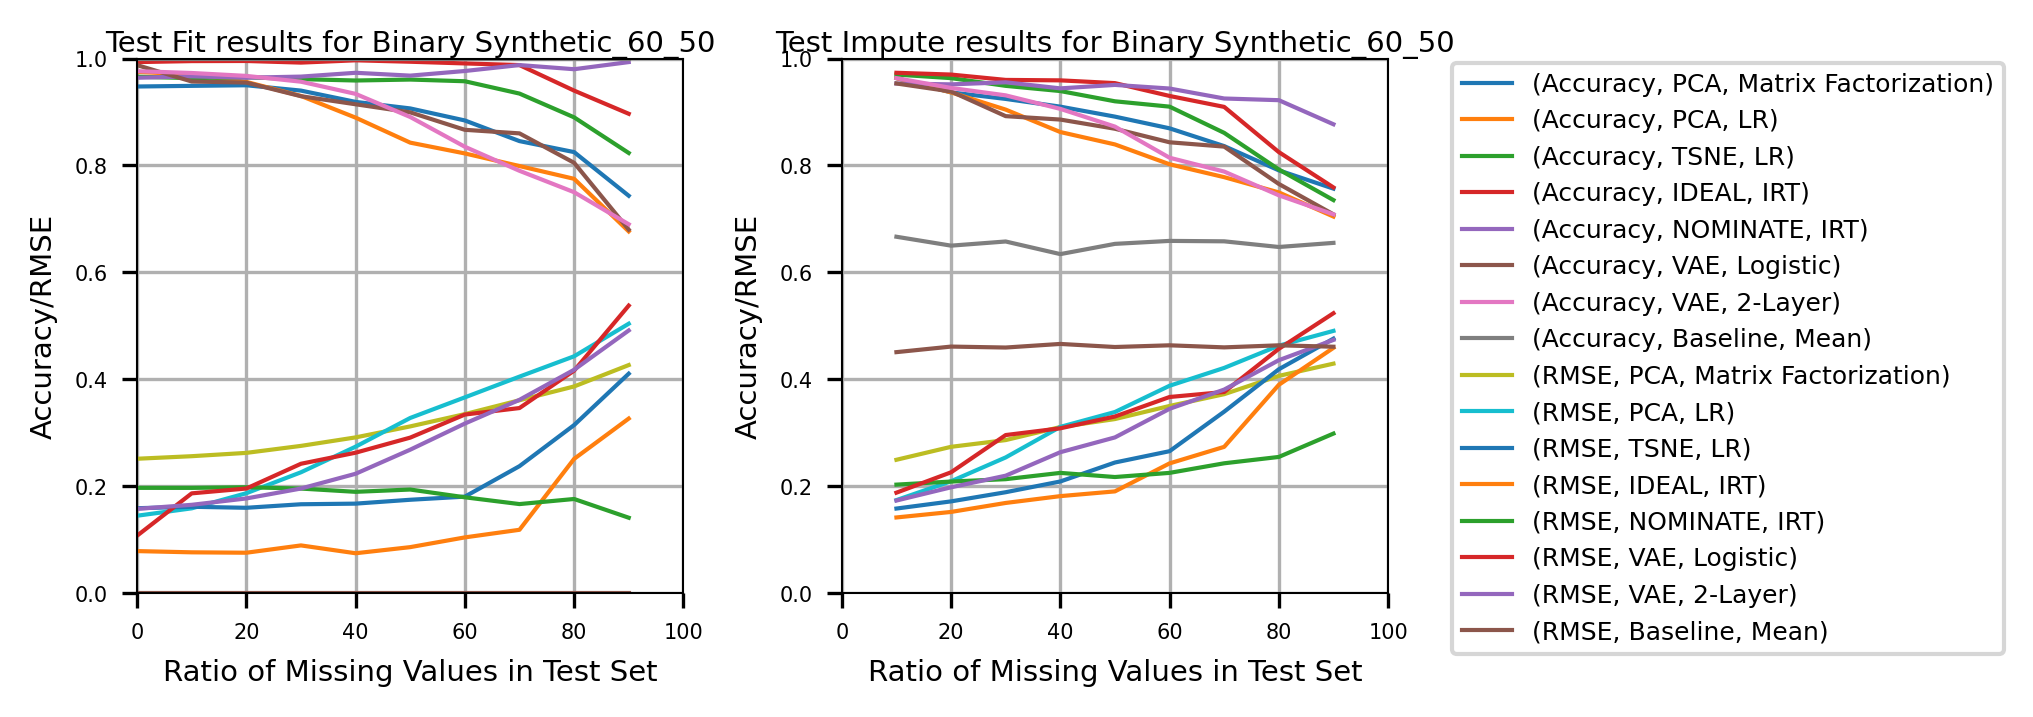

In [14]:
fig = overviewFitZero('Synthetic_60_50', 'Binary')

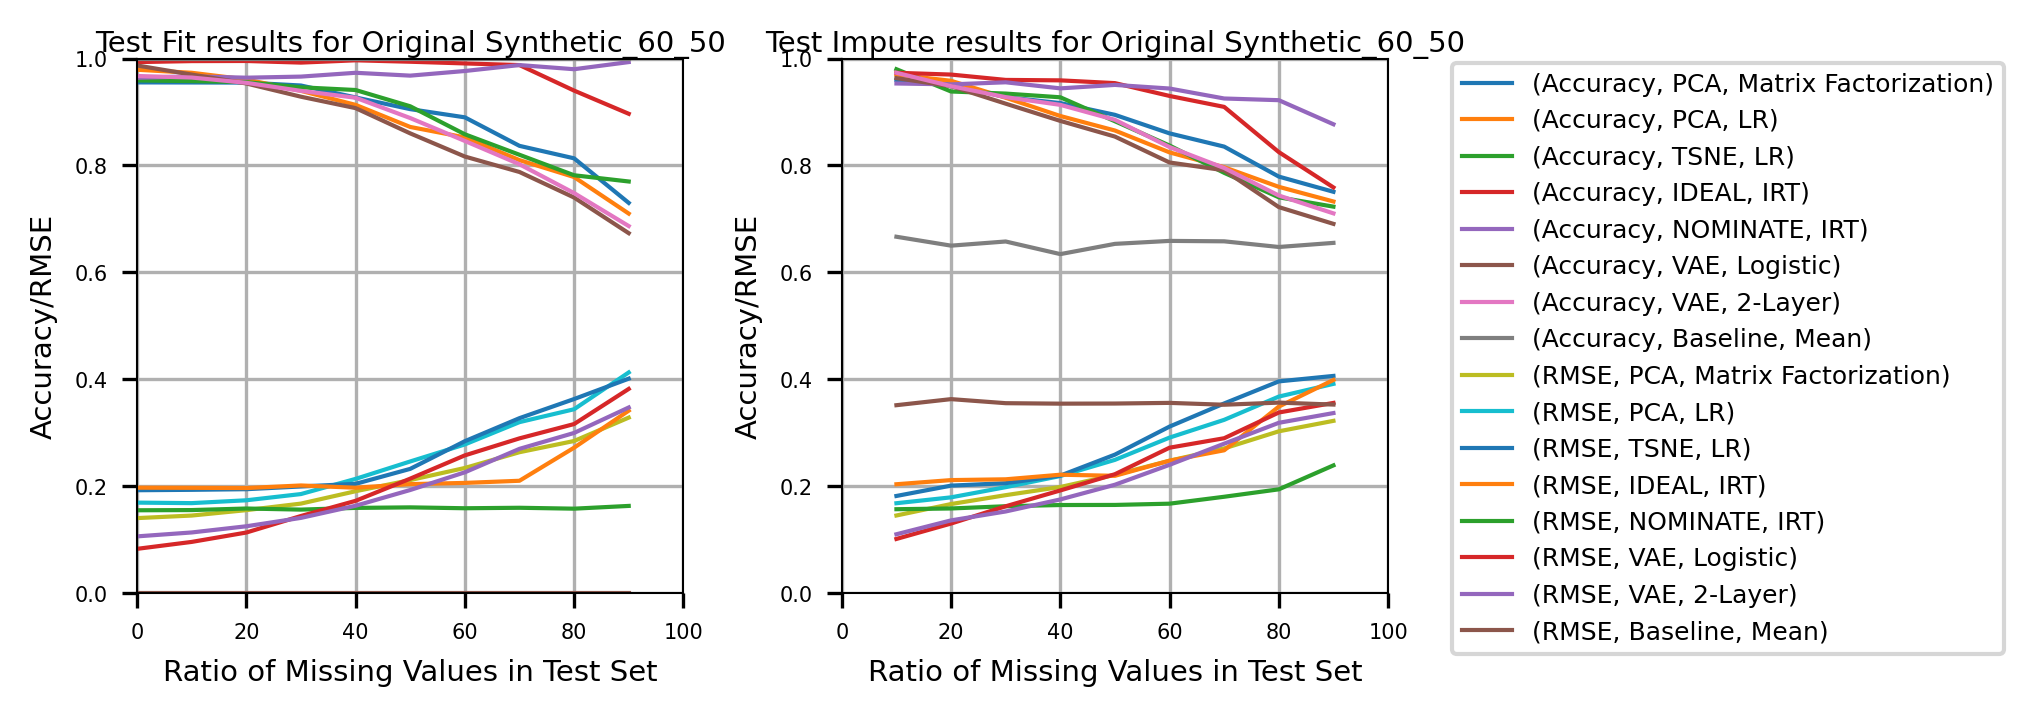

In [15]:
fig = overviewFitZero('Synthetic_60_50', 'Original')

## Smartvote 

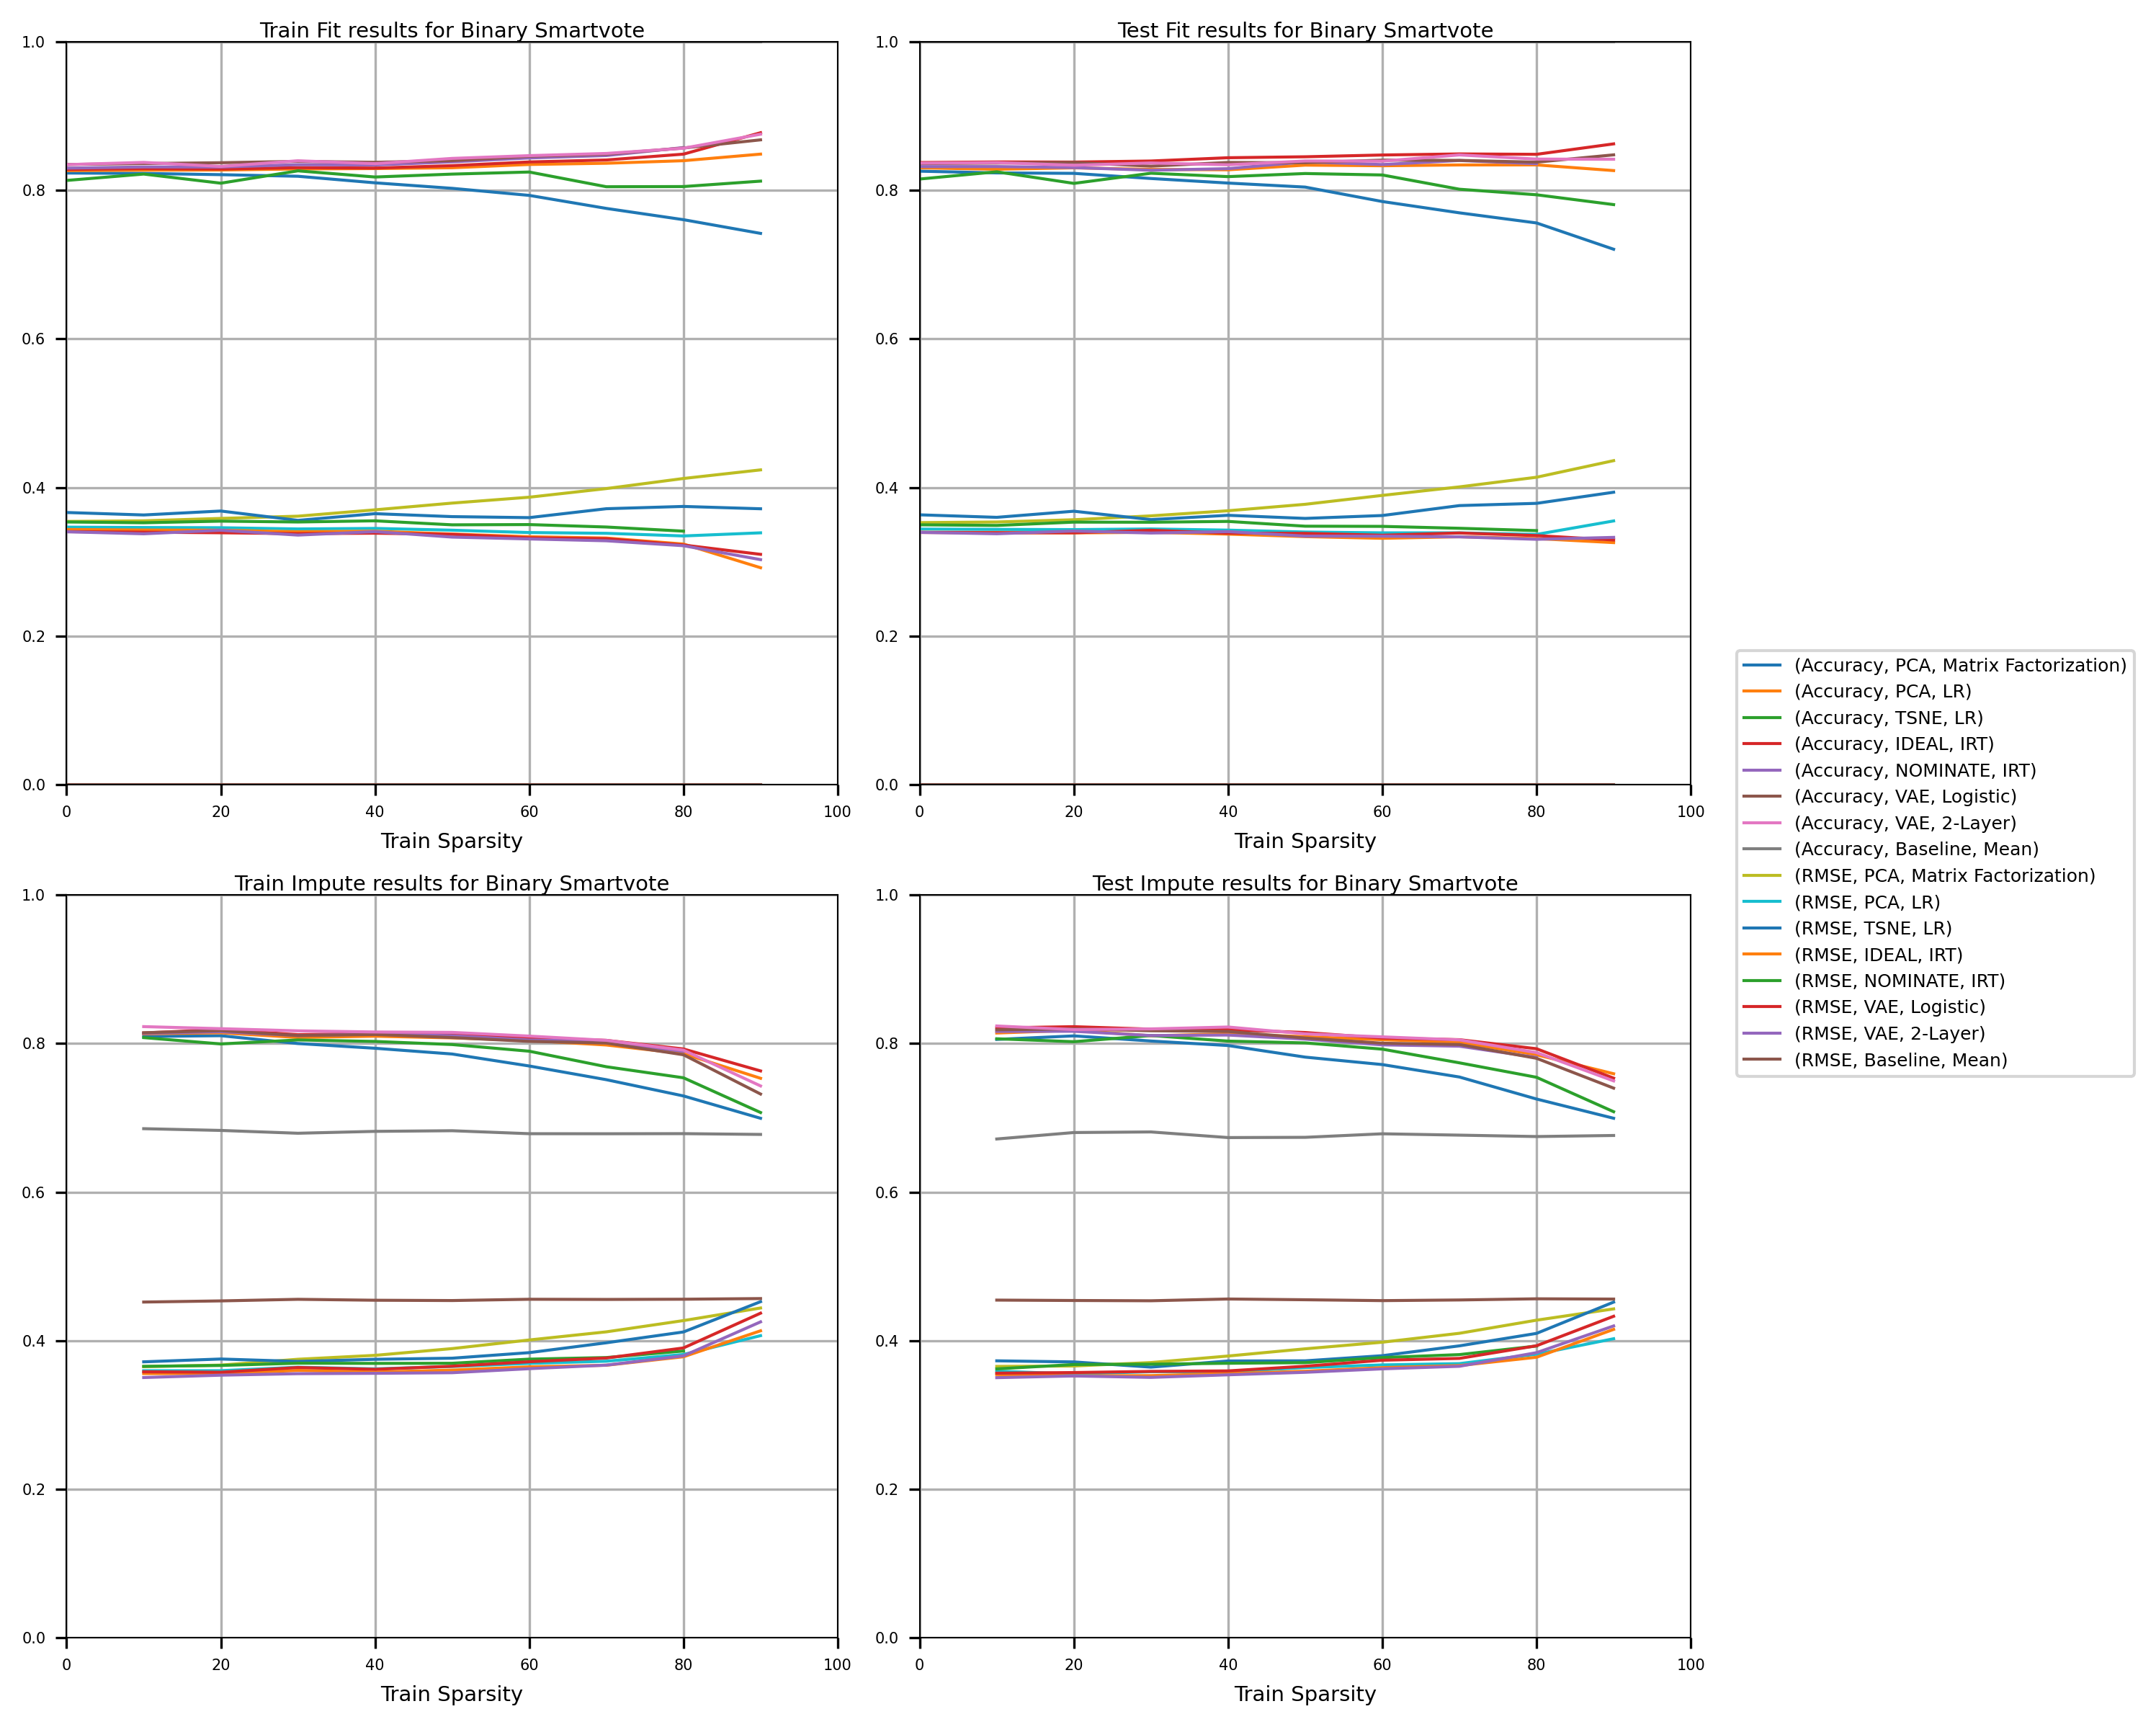

In [16]:
fig = overviewTrain('Smartvote', 'Binary')

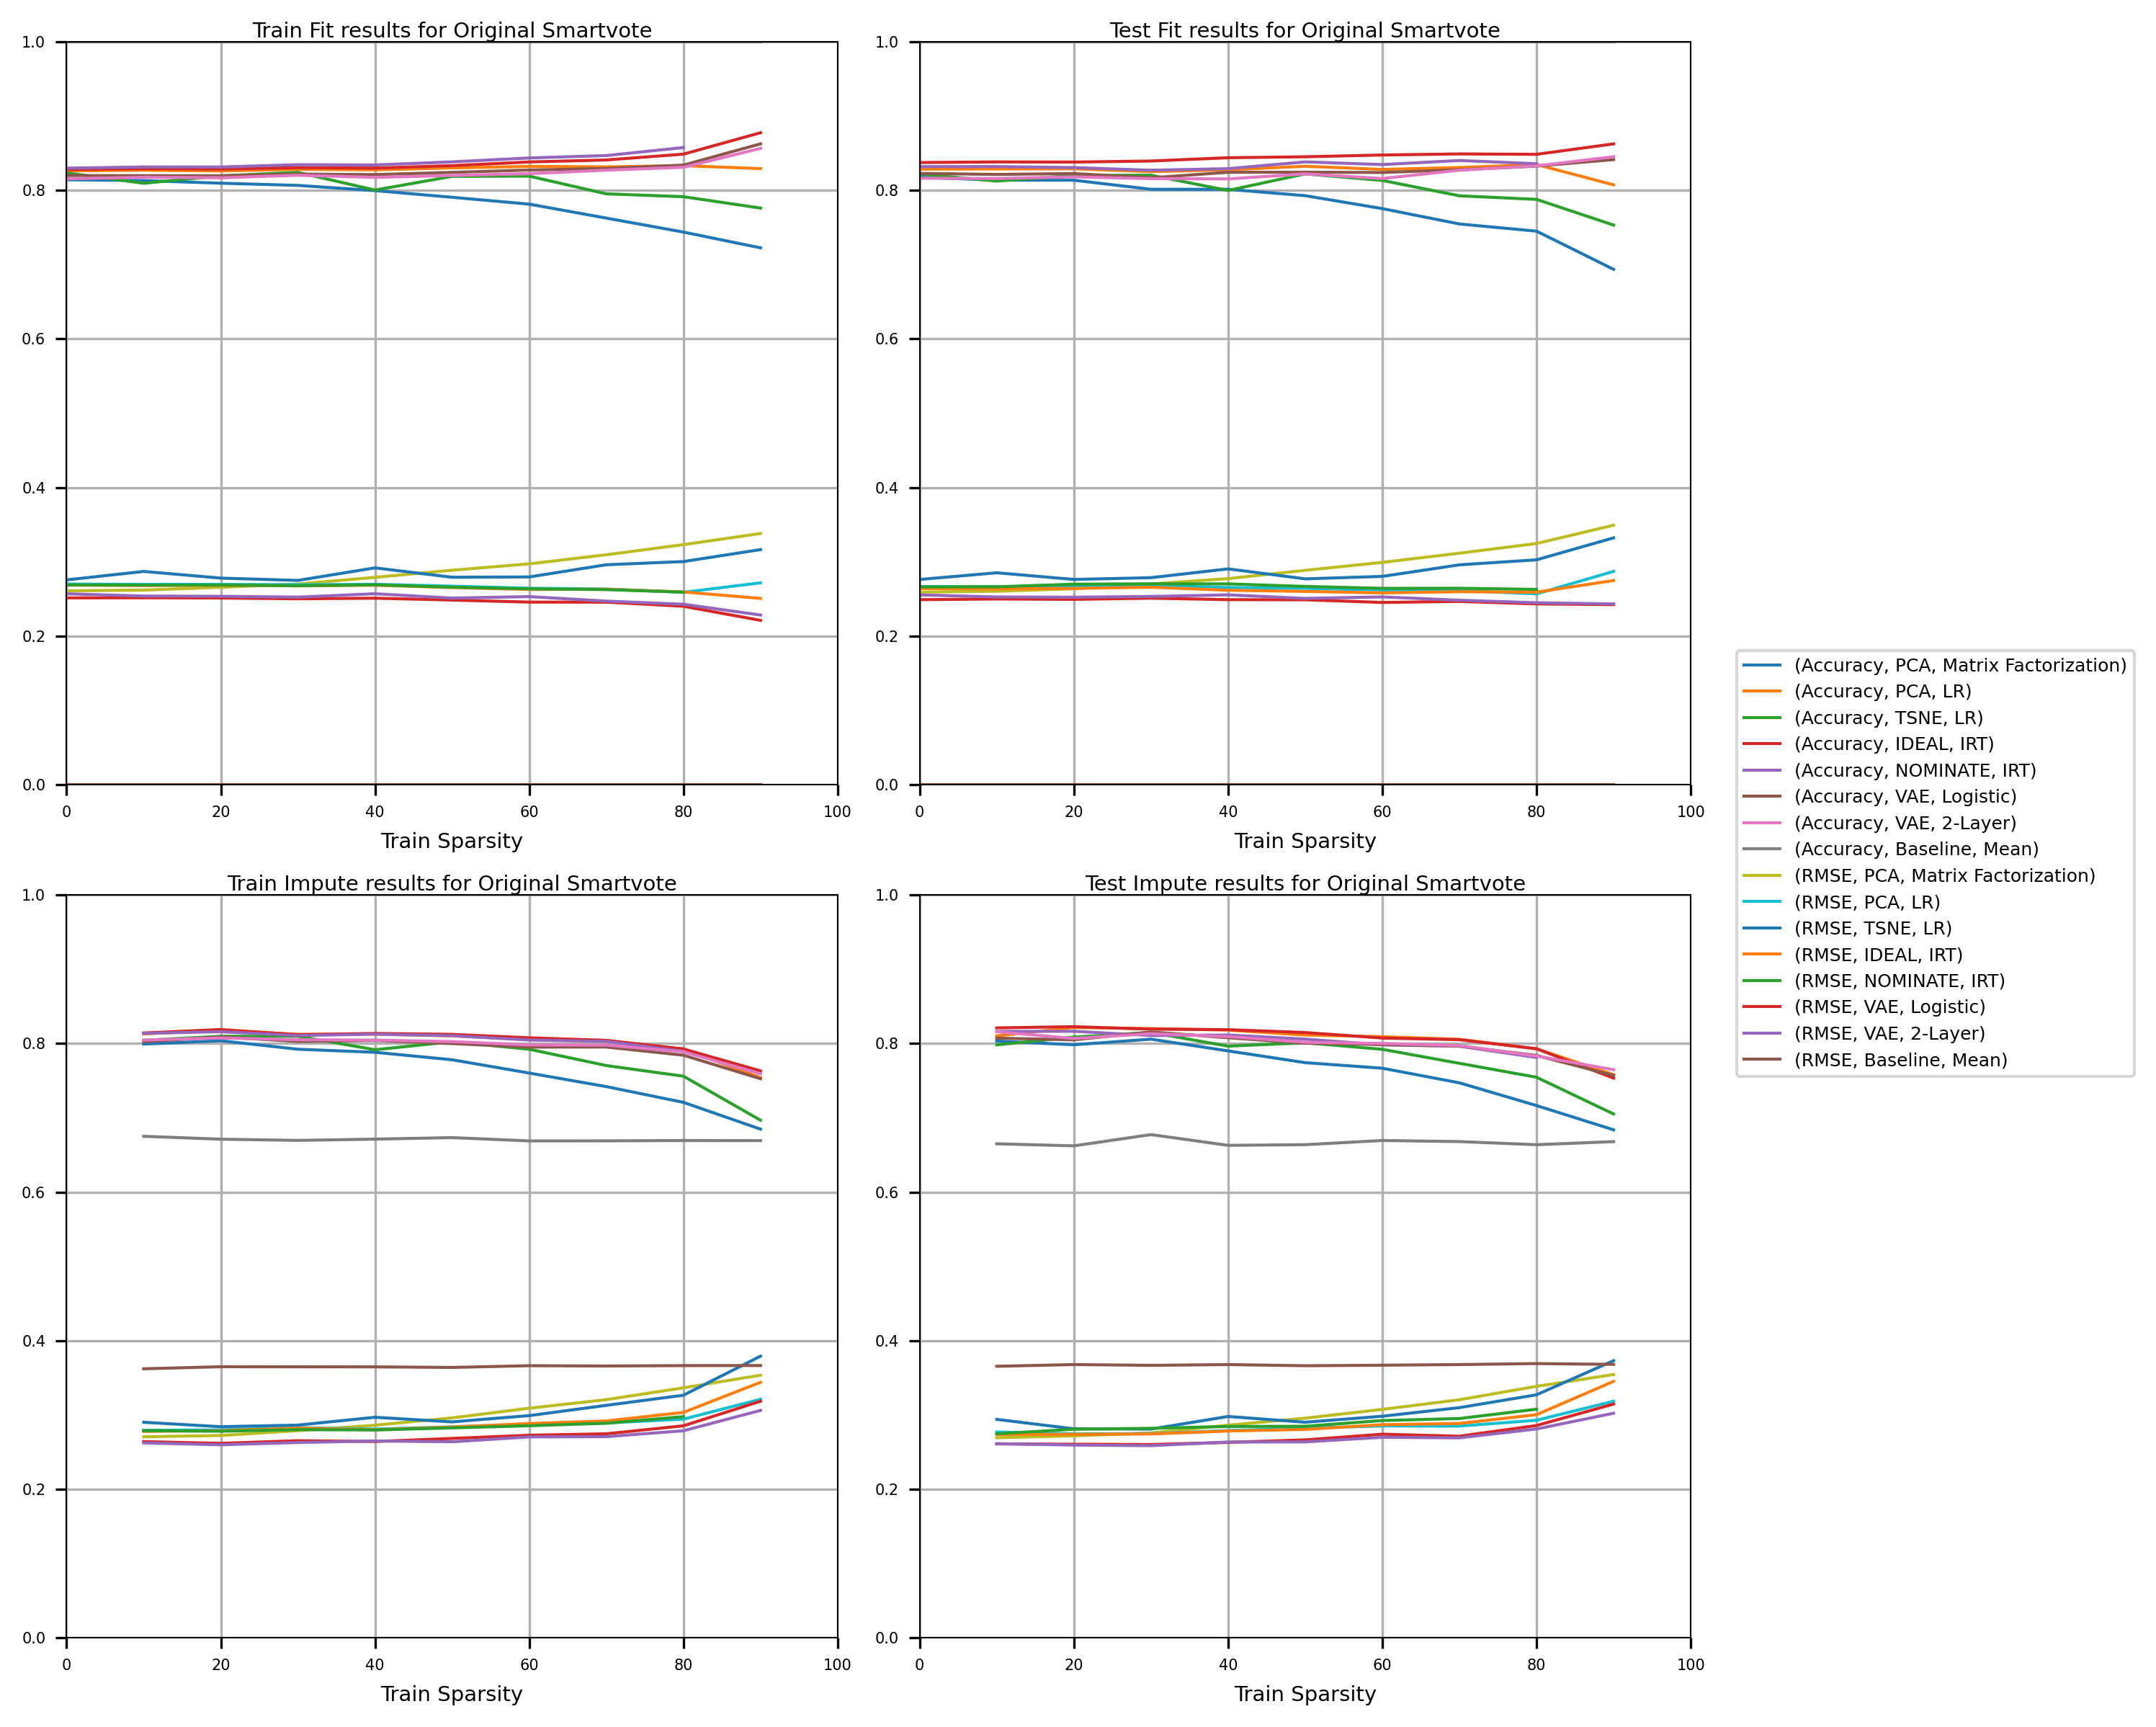

In [17]:
fig = overviewTrain('Smartvote', 'Original')

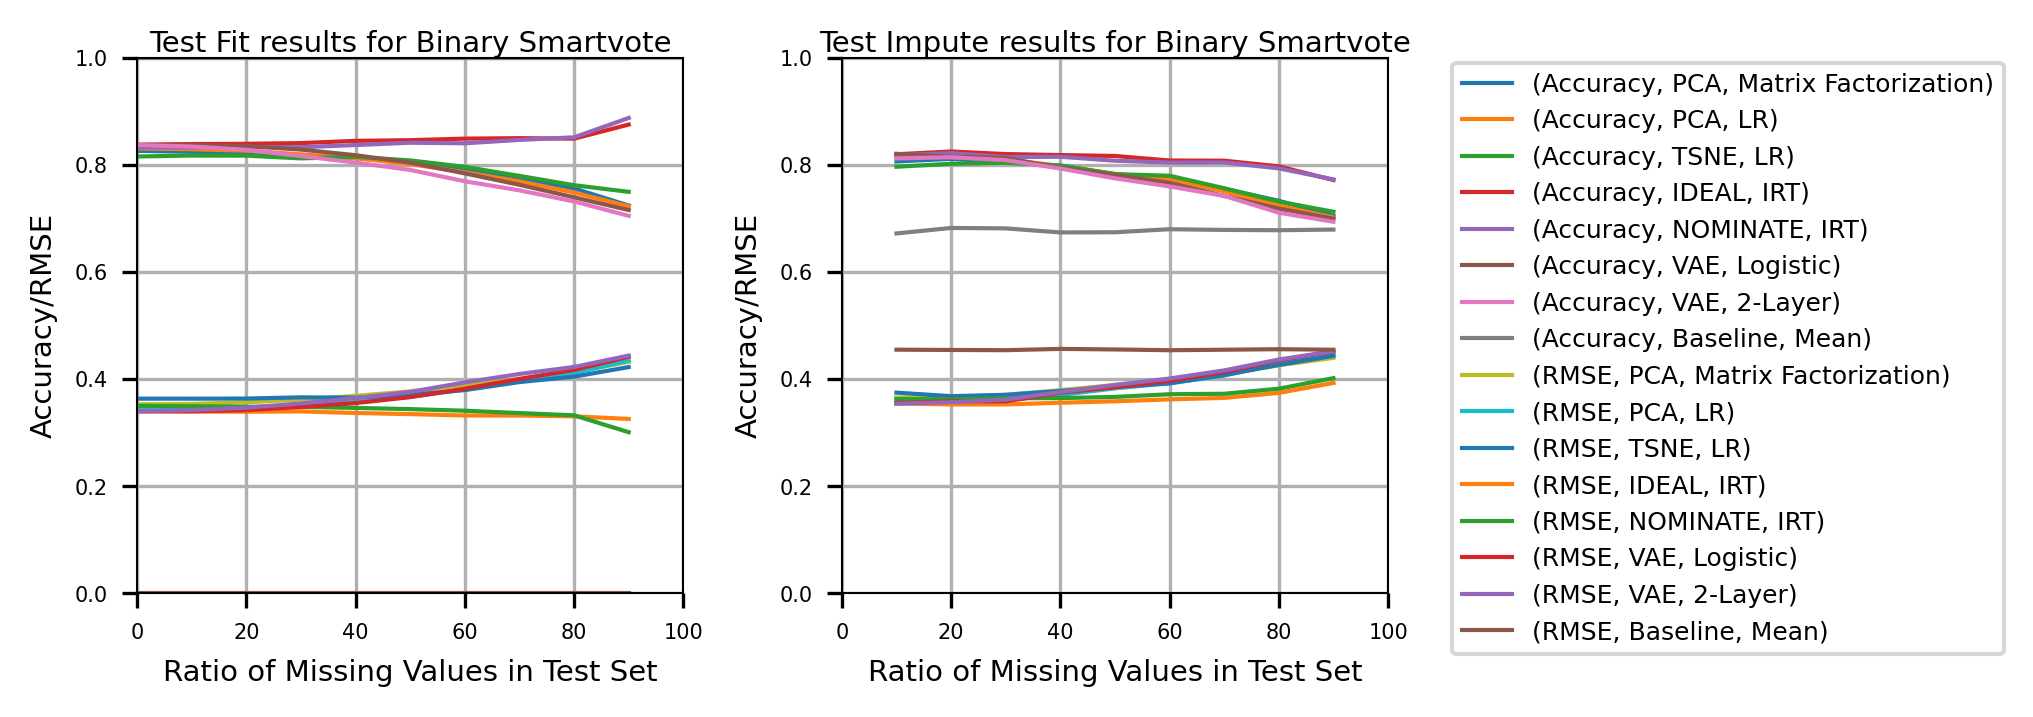

In [18]:
fig = overviewFitZero('Smartvote', 'Binary')

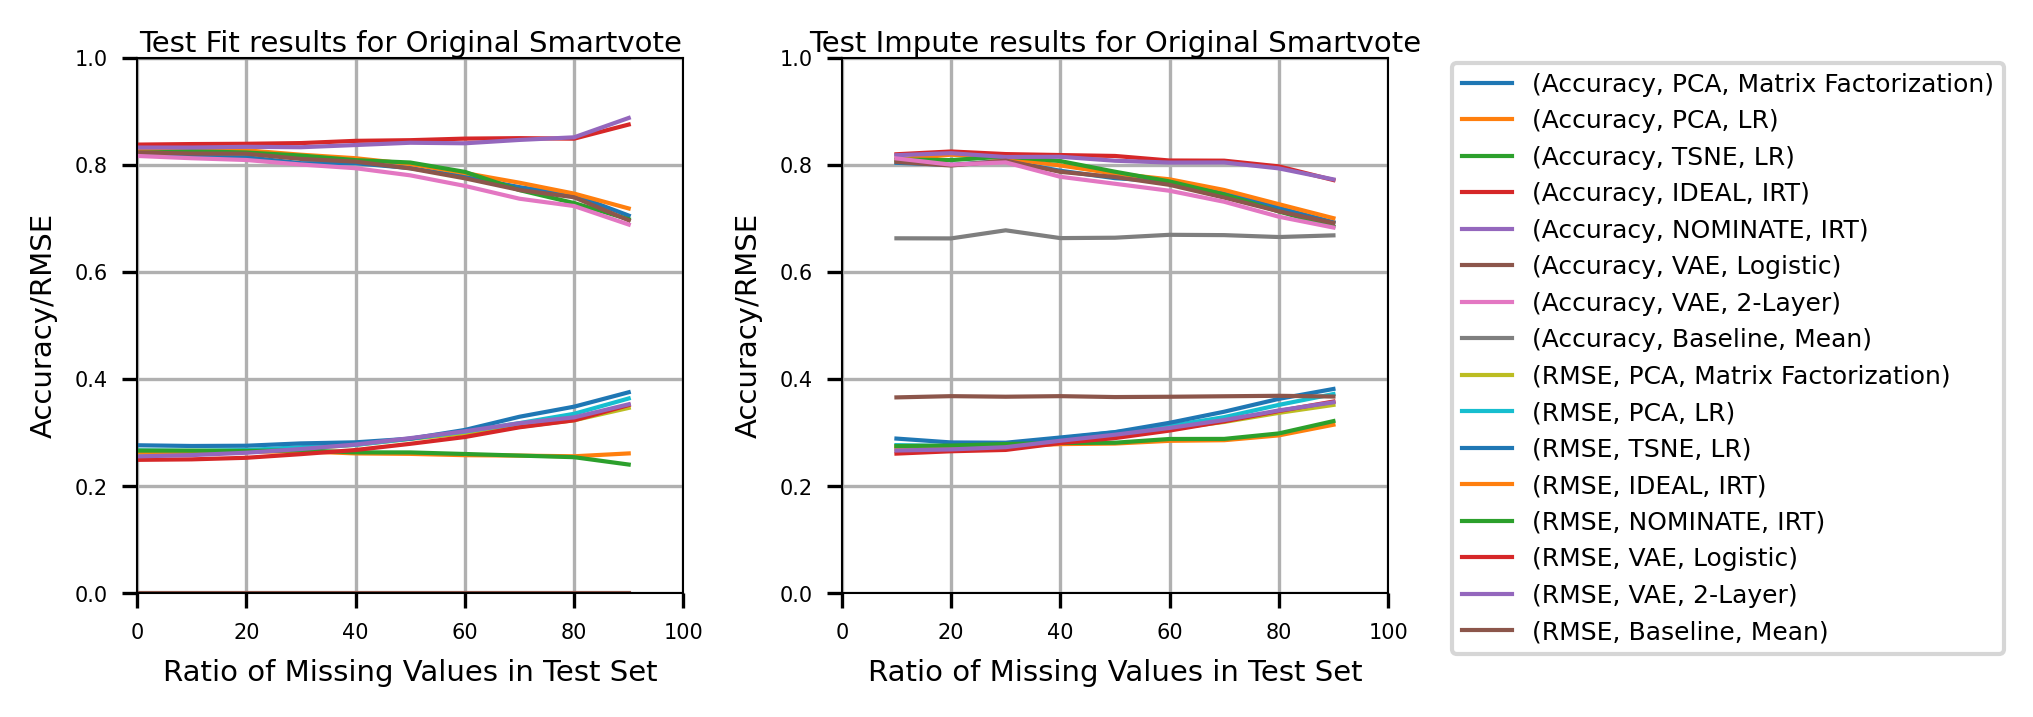

In [19]:
fig = overviewFitZero('Smartvote', 'Original')

## Tables

In [20]:
def table(dataset, datatype, p, task, metric):
    return results.loc[   (results['Dataset'] == dataset) 
                        & (results['Datatype'] == datatype) 
                        & (results['Task'] == task)
                        & (results['Train Sparsity'] == p)
                        & (results['Evaluation Sparsity'] == p)
                        ].set_index(['Embedding Method', 'Prediction Method', 'Evaluation Set']
                        ).loc[:,metric
                        ].unstack('Evaluation Set')

In [21]:
table('Synthetic_60_50', 'Binary', p=60, task = 'Impute', metric = 'RMSE')

Evaluation Set                             Test     Train
Embedding Method Prediction Method                       
Baseline         Mean                  0.463112  0.458314
IDEAL            IRT                   0.218500  0.191774
NOMINATE         IRT                   0.241714  0.241776
PCA              LR                    0.232122  0.238466
                 Matrix Factorization  0.353271  0.350154
TSNE             LR                    0.257163  0.232733
VAE              2-Layer               0.210160  0.212946
                 Logistic              0.280619  0.248602

In [22]:
table('Smartvote', 'Binary', p=0, task = 'Fit', metric = 'RMSE')

Evaluation Set                             Test     Train
Embedding Method Prediction Method                       
Baseline         Mean                  0.000000  0.000000
IDEAL            IRT                   0.339693  0.343390
NOMINATE         IRT                   0.349672  0.353488
PCA              LR                    0.343935  0.346528
                 Matrix Factorization  0.352643  0.354233
TSNE             LR                    0.363139  0.366280
VAE              2-Layer               0.339542  0.340319
                 Logistic              0.339399  0.340447

### Highscores

In [23]:
def highscore(dataset, datatype, metric = 'RMSE'):
    scores = results.loc[   (results['Dataset'] == dataset) 
                        & (results['Datatype'] == datatype) 
                        & (results['Train Sparsity'] == results['Evaluation Sparsity'])
                        & (results['Task'] != 'Overall') 
                        ].set_index(['Embedding Method', 'Prediction Method', 'Evaluation Set', 'Task', 'Evaluation Sparsity']
                        ).loc[:,metric
                        ].unstack(['Evaluation Set', 'Task', 'Evaluation Sparsity']).fillna(0.5)
    return scores.mean(axis=1)

In [24]:
highscore('Synthetic_60_50', 'Binary', metric='Accuracy')

Embedding Method  Prediction Method   
Baseline          Mean                    0.817120
IDEAL             IRT                     0.941868
NOMINATE          IRT                     0.842501
PCA               LR                      0.907151
                  Matrix Factorization    0.855925
TSNE              LR                      0.903827
VAE               2-Layer                 0.920816
                  Logistic                0.900860
dtype: float64

In [25]:
highscore('Synthetic_60_50', 'Original')

Embedding Method  Prediction Method   
Baseline          Mean                    0.183535
IDEAL             IRT                     0.235459
NOMINATE          IRT                     0.249744
PCA               LR                      0.198887
                  Matrix Factorization    0.234976
TSNE              LR                      0.244314
VAE               2-Layer                 0.148661
                  Logistic                0.146548
dtype: float64

In [26]:
highscore('Smartvote', 'Original', metric='RMSE')

Embedding Method  Prediction Method   
Baseline          Mean                    0.189804
IDEAL             IRT                     0.287605
NOMINATE          IRT                     0.309180
PCA               LR                      0.287633
                  Matrix Factorization    0.305993
TSNE              LR                      0.307271
VAE               2-Layer                 0.271820
                  Logistic                0.271539
dtype: float64

In [27]:
highscore('Smartvote', 'Binary', metric='Accuracy')

Embedding Method  Prediction Method   
Baseline          Mean                    0.830308
IDEAL             IRT                     0.808267
NOMINATE          IRT                     0.773652
PCA               LR                      0.801205
                  Matrix Factorization    0.770102
TSNE              LR                      0.783893
VAE               2-Layer                 0.808244
                  Logistic                0.805281
dtype: float64

In [28]:
folder_name = 'Smartvote'
# folder_name = 'Synthetic_60_50'

### Polis (Fitting)

When you want to just display the actual best (overfitted) representation of the data

In [36]:
polis_fit = results.loc[  (results['Dataset'] == folder_name) 
                        & (results['Datatype'] == 'Binary') 
                        & (results['Train Sparsity'] == results['Evaluation Sparsity'])
                        & (results['Evaluation Set'] == 'Train')
                        & (results['Task'] == 'Fit') 
                        ].set_index(['Embedding Method', 'Prediction Method', 'Evaluation Sparsity']
                        ).loc[:,'Accuracy'
                        ].unstack(['Evaluation Sparsity']).fillna(0.5).mean(axis=1)
polis_fit.round(3)

Embedding Method  Prediction Method   
Baseline          Mean                    1.000
IDEAL             IRT                     0.839
NOMINATE          IRT                     0.805
PCA               LR                      0.833
                  Matrix Factorization    0.797
TSNE              LR                      0.816
VAE               2-Layer                 0.845
                  Logistic                0.844
dtype: float64

### Polis (Robustness)
When you want to use this for comment routing so you need to know how the same users will answer the remaining questions, and you can train on the actual data

In [30]:
polis_impute = results.loc[   (results['Dataset'] == folder_name) 
                            & (results['Datatype'] == 'Binary') 
                            & (results['Train Sparsity'] == results['Evaluation Sparsity'])
                            & (results['Evaluation Set'] == 'Train')
                            & (results['Task'] == 'Impute') 
                            ].set_index(['Embedding Method', 'Prediction Method', 'Evaluation Sparsity']
                            ).loc[:,'Accuracy'
                            ].unstack(['Evaluation Sparsity']).fillna(0.5).mean(axis=1)

polis_impute.round(3)

Embedding Method  Prediction Method   
Baseline          Mean                    0.663
IDEAL             IRT                     0.774
NOMINATE          IRT                     0.746
PCA               LR                      0.770
                  Matrix Factorization    0.745
TSNE              LR                      0.753
VAE               2-Layer                 0.774
                  Logistic                0.768
dtype: float64

### Smartmap New Users (Generalization)
When you have the full candidate dataset and want to embed new users (or new candidates) into it (that may have missing values)

In [31]:
smartmap_fit = results.loc[   (results['Dataset'] == folder_name) 
                            & (results['Datatype'] == 'Original') 
                            & (results['Train Sparsity'] == 0)
                            & (results['Evaluation Set'] == 'Test')
                            & (results['Task'] == 'Fit') 
                            ].set_index(['Embedding Method', 'Prediction Method', 'Evaluation Sparsity']
                            ).loc[:,'RMSE'
                            ].unstack(['Evaluation Sparsity']).fillna(0.5).mean(axis=1)
smartmap_fit.round(3)

Embedding Method  Prediction Method   
Baseline          Mean                    0.000
IDEAL             IRT                     0.261
NOMINATE          IRT                     0.260
PCA               LR                      0.295
                  Matrix Factorization    0.290
TSNE              LR                      0.303
VAE               2-Layer                 0.291
                  Logistic                0.283
dtype: float64

### Smart Track (Generalization/Robustness)
When you have a full candidates matrix and want to embed new users into it, where you need to impute the remaining values for next question selection 

In [32]:
smartmap_impute = results.loc[(results['Dataset'] == folder_name) 
                            & (results['Datatype'] == 'Original') 
                            & (results['Train Sparsity'] == 0)
                            & (results['Evaluation Set'] == 'Test')
                            & (results['Task'] == 'Impute') 
                            ].set_index(['Embedding Method', 'Prediction Method', 'Evaluation Sparsity']
                            ).loc[:,'RMSE'
                            ].unstack(['Evaluation Sparsity']).fillna(0.5).mean(axis=1)
smartmap_impute.round(3)

Embedding Method  Prediction Method   
Baseline          Mean                    0.380
IDEAL             IRT                     0.306
NOMINATE          IRT                     0.309
PCA               LR                      0.328
                  Matrix Factorization    0.321
TSNE              LR                      0.334
VAE               2-Layer                 0.322
                  Logistic                0.318
dtype: float64

In [37]:
scores = pd.concat([polis_fit, polis_impute, smartmap_fit, smartmap_impute], axis=1)
scores.columns = ['Train Fit (%)', 'Train Impute (%)', 'Test Fit (RMSE)', 'Test Impute (RMSE)']
scores.round(3)

Train Fit (%)  Train Impute (%)  \
Embedding Method Prediction Method                                       
Baseline         Mean                          1.000             0.663   
IDEAL            IRT                           0.839             0.774   
NOMINATE         IRT                           0.805             0.746   
PCA              LR                            0.833             0.770   
                 Matrix Factorization          0.797             0.745   
TSNE             LR                            0.816             0.753   
VAE              2-Layer                       0.845             0.774   
                 Logistic                      0.844             0.768   

                                       Test Fit (RMSE)  Test Impute (RMSE)  
Embedding Method Prediction Method                                          
Baseline         Mean                            0.000               0.380  
IDEAL            IRT                             0.261               0.306  
NOMINATE         IRT                             0.260               0.309  
PCA              LR                              0.295               0.328  
                 Matrix Factorization            0.290               0.321  
TSNE             LR                              0.303               0.334  
VAE              2-Layer                         0.291               0.322  
                 Logistic                        0.283               0.318

In [38]:
# Define a function to bold the maximum values in a column
def bold_max(s):
    if '%' in s.name:
        is_max = s == s.max()
    else:
        is_max = s == s.min()

    return ['\\textbf{' + str(v) + '}' if max_val else str(v) for v, max_val in zip(s, is_max)]

# Round numbers to two decimal places
scores_rounded = scores.round(3)

# Convert the DataFrame to LaTeX code
latex_str = scores_rounded.apply(bold_max).to_latex(index=True, multirow=True,float_format="%.3f", caption=(f"Fit and Imputation results for four different settings. '"), label='tab:results')

# Print the LaTeX string (optional, for verification)
print(latex_str)

# Write the LaTeX string to a .tex file
# with open('../../reports/ecml-paper/tables/spatial_models_columns.tex', 'w') as texfile:
#     texfile.write(latex_str)


\begin{table}
\caption{Fit and Imputation results for four different settings. '}
\label{tab:results}
\begin{tabular}{llllll}
\toprule
 &  & Train Fit (%) & Train Impute (%) & Test Fit (RMSE) & Test Impute (RMSE) \\
Embedding Method & Prediction Method &  &  &  &  \\
\midrule
Baseline & Mean & \textbf{1.0} & 0.663 & \textbf{0.0} & 0.38 \\
\cline{1-6}
IDEAL & IRT & 0.839 & \textbf{0.774} & 0.261 & \textbf{0.306} \\
\cline{1-6}
NOMINATE & IRT & 0.805 & 0.746 & 0.26 & 0.309 \\
\cline{1-6}
\multirow[t]{2}{*}{PCA} & LR & 0.833 & 0.77 & 0.295 & 0.328 \\
 & Matrix Factorization & 0.797 & 0.745 & 0.29 & 0.321 \\
\cline{1-6}
TSNE & LR & 0.816 & 0.753 & 0.303 & 0.334 \\
\cline{1-6}
\multirow[t]{2}{*}{VAE} & 2-Layer & 0.845 & \textbf{0.774} & 0.291 & 0.322 \\
 & Logistic & 0.844 & 0.768 & 0.283 & 0.318 \\
\cline{1-6}
\bottomrule
\end{tabular}
\end{table}



## Figures for Paper

In [39]:

def plotScenario(dataset, datatype, stage, task, metric, fit_zero=False, ax=None):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(vis.textwidth, 0.5*vis.textwidth))

    if fit_zero:
        comparison = 0
        xlabel = 'Evaluation'
    else:
        xlabel = 'Train'
        comparison = results['Evaluation Sparsity']

    data = results.loc[ (results['Dataset'] == dataset) 
                    & (results['Datatype'] == datatype) 
                    & (results['Evaluation Set'] == stage) 
                    & (results['Task'] == task)
                    & (results['Train Sparsity'] == comparison)
                    ].set_index(['Embedding Method', 'Prediction Method', f'{xlabel} Sparsity']
                    ).loc[:,['Accuracy', 'RMSE']
                    ].unstack(['Embedding Method', 'Prediction Method'])
    
    for i, column in enumerate(data[metric]):
        ax.plot(data[metric].index, data[metric][column], color='C'+str(i), linestyle='-', label=f'{column}')  # First plot for each column

    ax.grid(True)
    ax.legend(ncol=2, facecolor='white')
    ax.set(xlabel=f'Ratio of Missing Values in {stage} Set',
        ylabel=f'{task} {metric}',
        title='')
    return fig, ax



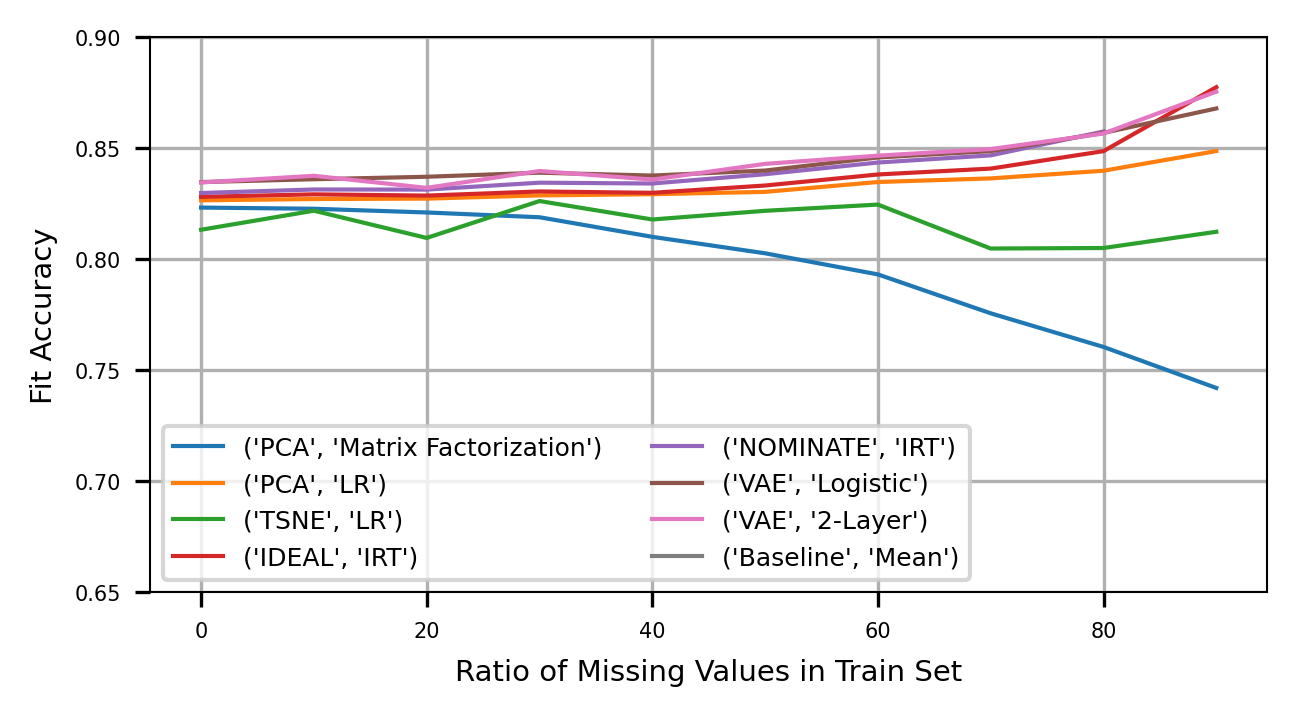

In [32]:
folder_name = 'Smartvote'
data_set = 'Train' 
task = 'Fit' 

data_name = 'Original'
metric = 'RMSE'
lim=[0.15,0.4]
fit_zero=True
if data_set == 'Train':
    data_name = 'Binary'
    metric = 'Accuracy'
    lim=[0.65,0.9]
    fit_zero=False


fig, ax = plotScenario(folder_name, data_name, data_set, task, metric, fit_zero=fit_zero)

ax.set(ylim=lim)

vis.savefig(fig, save_figures, 'ecml-paper', folder_name, data_name, name=f'{data_set}_{task}')
